In [1]:
%%bash 
export SUDO_ASKPASS=/Applications/Utilities/XQuartz.app/Contents/MacOS/X11
ln -sfhv /Library/Frameworks/R.framework/Versions/3.3 /Library/Frameworks/R.framework/Versions/Current

/Library/Frameworks/R.framework/Versions/Current -> /Library/Frameworks/R.framework/Versions/3.3


In [2]:
import sys
sys.path.insert(1,'/scicore/home/nimwegen/witzg/.local/lib/python3.5/site-packages')
sys.path.insert(1,'/scicore/home/nimwegen/witzg/MoMA_Python_Git/')
sys.path.insert(1, '/Users/guillaume/Desktop/PostdocBasel/MoMA_python_Git/')
import os

%load_ext rpy2.ipython
%R require(ggplot2)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Le chargement a nécessité le package : ggplot2

  warnings.warn(x, RRuntimeWarning)


array([1], dtype=int32)

In [3]:
from MMdata import MMData 
import numpy as np
import matplotlib.pyplot as plt
import re
import scipy.ndimage as nd

from skimage.measure import label, regionprops
from skimage import morphology
import pandas as pd

In [4]:
import platesegmenter as ps

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [5]:
folder = '/Volumes/MusiqueHD/201710126_lowerbound'
#folder = '/scicore/home/nimwegen/urchuegu/projects/prj_noise_across_conditions_main/cell_size/data/20170223/20170223_highmed_2'

In [6]:
weights_folder  = '/Users/guillaume/Desktop/PostdocBasel/PlateSegmenter_Python_Git/DeepPlate/Learn201710126/'

In [7]:
folder_to_save = '/Users/guillaume/Desktop/PostdocBasel/PlateData/201710126_lowerbound'

In [8]:
MMobj = MMData(folder = folder)
print(MMobj.channels)

['GFP', 'DIA (GFP)']


In [9]:
#based on the above outpout set fluo and bright field channels
fluo_ch = 0
bf_ch = 1

In [10]:
#load deep learning model and weights
plate_model = ps.get_unet(1, MMobj.height,MMobj.width)
plate_model.load_weights(weights_folder+'weights.h5')

In [11]:
#load training examples to get normalization
imgs_train, imgs_mask_train, imgs_weight_train = ps.load_train_data(weights_folder)

In [12]:
z_step = MMobj.get_zstep()
positions, well = ps.get_position_names(MMobj)
well_index = np.ravel([[x for x in range(well.shape[0]) if well[x] in y] for y in positions])
well_str = well[well_index]

In [14]:
for i in range(1):#range(len(positions)):
    
    #load bf stack
    stack = MMobj.get_stack(frame=0,channel=bf_ch,position=i, compress = 1)
    
    #calculate correlation image
    correlated_norm = ps.phase_corr_simple(stack,thickness=800,z_step=z_step)
    correlated_norm_gauss = nd.gaussian_filter(correlated_norm,3)
    
    #deep-segment image
    plate_im = correlated_norm_gauss.astype('float32')-np.mean(imgs_train)
    plate_im = plate_im/np.std(imgs_train)
    plate_im = plate_im[np.newaxis,...,np.newaxis]
    plate_im_mask = plate_model.predict(plate_im, verbose=1)
    plate_im_mask = np.reshape(plate_im_mask,correlated_norm.shape)
    
    #threshold deepe learning segmentation and clean resulting mask
    plate_im_mask2 = plate_im_mask.copy()
    plate_im_mask2[plate_im_mask2<0.9]=0
    plate_im_mask2[plate_im_mask2>0.9]=1

    masklab = morphology.label(plate_im_mask2)
    cellinfo = regionprops(masklab)
    newMask = np.zeros(masklab.shape)
    for c in cellinfo:
        if (c.label>0)&(c.area>10)&(c.area<10000):
            newMask[masklab==c.label]=1
    
    #load fluo image
    im_fluo = MMobj.get_stack(frame=0,channel=fluo_ch,position=i, compress = 1)[:,:,0]
    #calculate local properties
    cell_info = regionprops(label(newMask),im_fluo)
    
    mean_int = [x.mean_intensity for x in cell_info]
    posx = [x.centroid[0] for x in cell_info]
    posy = [x.centroid[1] for x in cell_info]
    #create a dataframe
    cell_struct = {'mean_fluo':mean_int,'posx': posx, 'posy': posy}
    cell_frame = pd.DataFrame(cell_struct)
    
    

[   2.65147892    6.12497513   13.22378      26.66159169   50.14719794
   87.87386725  143.20711569  216.53645318  302.77123356  389.58296083
  457.83336177  485.22452777  452.90376119  352.99876103  193.8466469    -0.
 -193.8466469  -352.99876103 -452.90376119 -485.22452777 -457.83336177
 -389.58296083 -302.77123356 -216.53645318 -143.20711569  -87.87386725
  -50.14719794  -26.66159169  -13.22378      -6.12497513   -2.65147892]
1/1 [==============================] - 63s 63s/step


In [15]:
mean_int = [x.mean_intensity for x in cell_info]
posx = [x.centroid[0] for x in cell_info]
posy = [x.centroid[1] for x in cell_info]
#create a dataframe
cell_struct = {'mean_fluo':mean_int,'posx': posx, 'posy': posy}
cell_frame = pd.DataFrame(cell_struct)

In [16]:
cell_frame['well'] = well_str[i]
cell_frame['position'] = positions[i]

In [17]:
cell_frame

,mean_fluo,posx,posy,well,position
0,1452.750000,5.620690,17.853448,B11,B11-Site_0
1,1763.379310,3.160920,296.862069,B11,B11-Site_0
2,1851.392857,9.821429,222.383929,B11,B11-Site_0
3,1933.000000,15.835165,580.637363,B11,B11-Site_0
4,1509.928571,14.809524,1642.011905,B11,B11-Site_0
5,1256.016667,11.316667,1788.700000,B11,B11-Site_0
6,1365.509804,13.901961,1896.019608,B11,B11-Site_0
7,1408.034783,21.121739,51.713043,B11,B11-Site_0
8,1159.321839,21.172414,1812.678161,B11,B11-Site_0
9,1812.685714,21.714286,626.885714,B11,B11-Site_0


In [18]:
if not os.path.exists(folder_to_save):
    os.makedirs(folder_to_save)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

  warnings.warn(x, RRuntimeWarning)


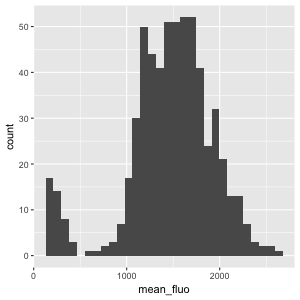

In [19]:
%%R -i cell_frame,folder_to_save -w 300 -h 300 -u px
x<-ggplot(NULL)+
geom_histogram(data=cell_frame,aes(x=mean_fluo))
print(x)

location<-paste(folder_to_save,cell_frame[0,'position'],'.Rda',sep = "")
save(cell_frame,file=location)

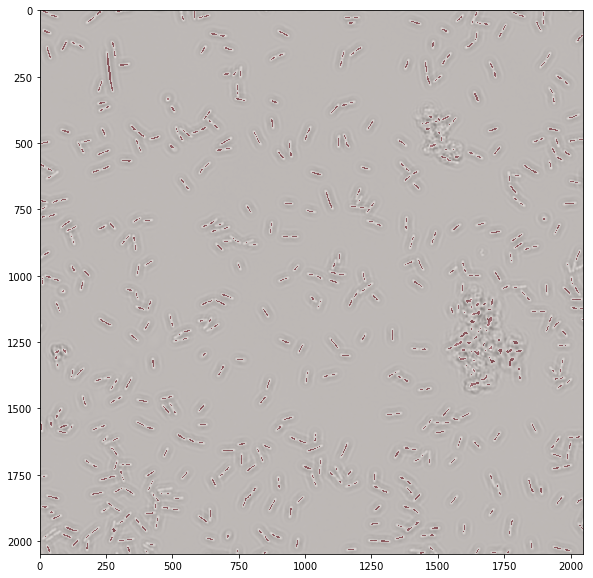

In [23]:
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(correlated_norm_gauss,cmap='gray')
plt.imshow(plate_im_mask2,cmap='Reds',alpha = 0.5)
plt.show()